In [4]:
import numpy as np
import scipy.spatial

from functools import partial
import timeit
import matplotlib.pyplot as plt
import itertools

from utils import median_heuristic

#### rMMD

In [3]:
def rMMDstat(
    X,
    Y,
    seed,
    bandwidth = 1,
    kernel ='gaussian',
    R = 20,
    stat_type = 'U',
):
    '''
    [Input and output]
        (Input)
            X: array_like
                The shape of X must be of the form (m, d) where m is the number
                of samples and d is the dimension.
            Y: array_like
                The shape of Y must be of the form (n, d) where n is the number
                of samples and d is the dimension.

        (Output)
            Delta: int
                The value of delta must be 0 or 1;
                    return 0 if the test ACCEPTS the null
                 or return 1 if the test REJECTS the null 


    [Parameters]
        alpha: scalar
            The value of alpha must be between 0 and 1.
        kernel: str
            The value of kernel must be, "gaussian", ...
        bandwidth: scalar:
            The value of bandwidth must be between 0 and 1.
        R: int
            The number of random Fourier features.
        stat_type: str
            The value must be 'U' or 'V'; U-statistic or V-statistic.
        B: int
            The number of simulated test statistics to approximate the quantiles.
        seed:
            Random seed for the randomness of permutations and Fourier features.
    '''
    
    m, d = X.shape
    n = Y.shape[0]

    # feature mapping
    rs = np.random.RandomState(seed)

    
    if kernel == 'gaussian':
        omegas = rs.normal(scale=np.sqrt(2) / bandwidth, size=(R, d))

    omegas_X= np.dot(X, omegas.T) # m x R

    cos_feature_X = (1/np.sqrt(R)) * np.cos(omegas_X) # m x R
    sin_feature_X = (1/np.sqrt(R)) * np.sin(omegas_X) # m x R
    mean_cf_X = np.mean(cos_feature_X, axis = 0)
    mean_sf_X = np.mean(sin_feature_X, axis = 0)
    
    omegas_Y= np.dot(Y, omegas.T) # n x R

    cos_feature_Y = (1/np.sqrt(R)) * np.cos(omegas_Y) # n x R
    sin_feature_Y = (1/np.sqrt(R)) * np.sin(omegas_Y) # n x R
    mean_cf_Y = np.mean(cos_feature_Y, axis = 0)
    mean_sf_Y = np.mean(sin_feature_Y, axis = 0)

    T_cos = mean_cf_X-mean_cf_Y
    T_sin = mean_sf_X-mean_sf_Y

    V_cos = np.sum(T_cos ** 2)
    V_sin = np.sum(T_sin ** 2)

    V = V_cos + V_sin
    
    if stat_type == 'V':
        test_stats = V

    elif stat_type == 'U':
        W = 1/(m-1) - (1/(m-1)) * (np.sum(mean_cf_X ** 2)+np.sum(mean_sf_X ** 2))  + 1/(n-1) - (1/(n-1)) * (np.sum(mean_cf_Y ** 2)+np.sum(mean_sf_Y ** 2))
        U = V - W
        test_stats = U

    return test_stats

#### incMMD

In [4]:
def incMMDstat(
    X, 
    Y,
    seed,
    bandwidth=None,
    R= 200
):
        
    # bandwidth: use provided one or compute median heuristic
    if bandwidth is not None:
        bandwidths = np.array(bandwidth).reshape(1)
        
    # compute all h-values
    h_values, index_i, index_j, N = compute_h_MMD_values(
        X, Y, R, bandwidths, return_indices_N=True
    )
    
    original_value = h_values @ np.ones(h_values.shape[1]) / len(index_i)
    

    return original_value 


def create_indices(N, R):
    """
    Return lists of indices of R superdiagonals of N x N matrix
    
    This function can be modified to compute any type of incomplete U-statistic.
    """
    index_X = list(
        itertools.chain(*[[i for i in range(N - r)] for r in range(1, R + 1)])
    )
    index_Y = list(
        itertools.chain(*[[i + r for i in range(N - r)] for r in range(1, R + 1)])
    )
    return index_X, index_Y


def compute_h_MMD_values(X, Y, R, bandwidths, return_indices_N=False):
    """
    Compute h_MMD values.

    inputs:
        X (m,d)
        Y (n,d)
        R int
        bandwidths (#bandwidths,)

    output (#bandwidths, R * N - R * (R - 1) / 2)
    """
    N = min(X.shape[0], Y.shape[0])
    assert X.shape[1] == Y.shape[1]

    index_i, index_j = create_indices(N, R)
    
    norm_Xi_Xj = np.linalg.norm(X[np.array(index_i)] - X[np.array(index_j)], axis=1) ** 2
    norm_Xi_Yj = np.linalg.norm(X[np.array(index_i)] - Y[np.array(index_j)], axis=1) ** 2
    norm_Yi_Xj = np.linalg.norm(Y[np.array(index_i)] - X[np.array(index_j)], axis=1) ** 2
    norm_Yi_Yj = np.linalg.norm(Y[np.array(index_i)] - Y[np.array(index_j)], axis=1) ** 2

    h_values = np.zeros((bandwidths.shape[0], norm_Xi_Xj.shape[0]))
    for r in range(bandwidths.shape[0]):
        K_Xi_Xj_b = np.exp(-norm_Xi_Xj / bandwidths[r] ** 2)
        K_Xi_Yj_b = np.exp(-norm_Xi_Yj / bandwidths[r] ** 2)
        K_Yi_Xj_b = np.exp(-norm_Yi_Xj / bandwidths[r] ** 2)
        K_Yi_Yj_b = np.exp(-norm_Yi_Yj / bandwidths[r] ** 2)
        h_values[r] = K_Xi_Xj_b - K_Xi_Yj_b - K_Yi_Xj_b + K_Yi_Yj_b

    if return_indices_N:
        return h_values, index_i, index_j, N
    else:
        return h_values

#### lMMD

In [5]:
def lMMDstat(
    X, 
    Y,
    seed,
    bandwidth=None
):
        
    # bandwidth: use provided one or compute median heuristic
    if bandwidth is not None:
        bandwidths = np.array(bandwidth).reshape(1)

        
    # compute all h-values
    h_values, index_i, index_j, N = compute_h_MMD_values_linear(
        X, Y, bandwidths, return_indices_N=True
    )
    
    original_value = h_values @ np.ones(h_values.shape[1]) / len(index_i)
    

    return original_value 

def create_indices_linear(N):
    """
    Return lists of indices of R superdiagonals of N x N matrix
    
    This function can be modified to compute any type of incomplete U-statistic.
    """
    assert N % 2 ==0
    index_X = list(
        itertools.chain(*[[2*i for i in range(int(N/2))]])
    )
    index_Y = list(
        itertools.chain(*[[2*i+1 for i in range(int(N/2))]])
    )
    return index_X, index_Y

def compute_h_MMD_values_linear(X, Y, bandwidths, return_indices_N=False):
    """
    Compute h_MMD values.

    inputs:
        X (m,d)
        Y (n,d)
        R int
        bandwidths (#bandwidths,)

    output (#bandwidths, R * N - R * (R - 1) / 2)
    """
    N = min(X.shape[0], Y.shape[0])
    assert X.shape[1] == Y.shape[1]

    index_i, index_j = create_indices_linear(N)
    
    norm_Xi_Xj = np.linalg.norm(X[np.array(index_i)] - X[np.array(index_j)], axis=1) ** 2
    norm_Xi_Yj = np.linalg.norm(X[np.array(index_i)] - Y[np.array(index_j)], axis=1) ** 2
    norm_Yi_Xj = np.linalg.norm(Y[np.array(index_i)] - X[np.array(index_j)], axis=1) ** 2
    norm_Yi_Yj = np.linalg.norm(Y[np.array(index_i)] - Y[np.array(index_j)], axis=1) ** 2

    h_values = np.zeros((bandwidths.shape[0], norm_Xi_Xj.shape[0]))
    for r in range(bandwidths.shape[0]):
        K_Xi_Xj_b = np.exp(-norm_Xi_Xj / bandwidths[r] ** 2)
        K_Xi_Yj_b = np.exp(-norm_Xi_Yj / bandwidths[r] ** 2)
        K_Yi_Xj_b = np.exp(-norm_Yi_Xj / bandwidths[r] ** 2)
        K_Yi_Yj_b = np.exp(-norm_Yi_Yj / bandwidths[r] ** 2)
        h_values[r] = K_Xi_Xj_b - K_Xi_Yj_b - K_Yi_Xj_b + K_Yi_Yj_b

    if return_indices_N:
        return h_values, index_i, index_j, N
    else:
        return h_values

#### bMMD

In [6]:
def bMMDstat(
    X, 
    Y,
    seed,
    bandwidth=None
):
        
    # bandwidth: use provided one or compute median heuristic
    if bandwidth is not None:
        bandwidths = np.array(bandwidth).reshape(1)

        
    # compute all h-values
    h_values, index_i, index_j, N = compute_h_MMD_values_block(
        X, Y, bandwidths, return_indices_N=True
    )
    
    original_value = h_values @ np.ones(h_values.shape[1]) / len(index_i)
    

    return original_value 

def create_indices_block(N):

    B= np.floor(np.sqrt(N)).astype(int)
    """
    Return lists of indices of R superdiagonals of N x N matrix
    
    This function can be modified to compute any type of incomplete U-statistic.
    """
    index_X = list(itertools.chain(*
        itertools.chain(*[[[a for a in range(b*B,i+1)] for i in range(b*B,(b+1)*B-1)] for b in range(0,np.floor(N/B).astype(int))])
    ))
    index_Y = list(itertools.chain(*
        itertools.chain(*[[[i+1 for a in range(b*B,i+1)] for i in range(b*B,(b+1)*B-1)] for b in range(0,np.floor(N/B).astype(int))])
    ))
    return index_X, index_Y

def compute_h_MMD_values_block(X, Y, bandwidths, return_indices_N=False):
    """
    Compute h_MMD values.

    inputs:
        X (m,d)
        Y (n,d)
        R int
        bandwidths (#bandwidths,)

    output (#bandwidths, R * N - R * (R - 1) / 2)
    """
    N = min(X.shape[0], Y.shape[0])
    assert X.shape[1] == Y.shape[1]

    index_i, index_j = create_indices_block(N)
    
    norm_Xi_Xj = np.linalg.norm(X[np.array(index_i)] - X[np.array(index_j)], axis=1) ** 2
    norm_Xi_Yj = np.linalg.norm(X[np.array(index_i)] - Y[np.array(index_j)], axis=1) ** 2
    norm_Yi_Xj = np.linalg.norm(Y[np.array(index_i)] - X[np.array(index_j)], axis=1) ** 2
    norm_Yi_Yj = np.linalg.norm(Y[np.array(index_i)] - Y[np.array(index_j)], axis=1) ** 2

    h_values = np.zeros((bandwidths.shape[0], norm_Xi_Xj.shape[0]))
    for r in range(bandwidths.shape[0]):
        K_Xi_Xj_b = np.exp(-norm_Xi_Xj / bandwidths[r] ** 2)
        K_Xi_Yj_b = np.exp(-norm_Xi_Yj / bandwidths[r] ** 2)
        K_Yi_Xj_b = np.exp(-norm_Yi_Xj / bandwidths[r] ** 2)
        K_Yi_Yj_b = np.exp(-norm_Yi_Yj / bandwidths[r] ** 2)
        h_values[r] = K_Xi_Xj_b - K_Xi_Yj_b - K_Yi_Xj_b + K_Yi_Yj_b

    if return_indices_N:
        return h_values, index_i, index_j, N
    else:
        return h_values

#### MMD

In [7]:
MMDstat_2 = lambda X, Y, seed, bandwidth : incMMDstat(X, Y, seed=seed, bandwidth=bandwidth, R=X.shape[0]-1)

### Compare

In [8]:
def sampler_normal(seed, N):
    rs = np.random.RandomState(seed)
    X = rs.normal(0, 1, size=(N,1))
    Y = rs.normal(0.15, 1, size=(N,1)) 
    return X, Y

rMMDstat_1=partial(rMMDstat, R=10)
rMMDstat_2=partial(rMMDstat, R=200)
rMMDstat_3=partial(rMMDstat, R=1000)
incMMDstat_1=partial(incMMDstat, R=100)
incMMDstat_2=partial(incMMDstat, R=200)
sample_sizes = [250,500,1000,2000,4000,8000]
d = 1

tests = (MMDstat_2, rMMDstat_1, rMMDstat_2, rMMDstat_3, incMMDstat_1, incMMDstat_2, lMMDstat, bMMDstat)
time_mean = np.zeros((len(tests), len(sample_sizes)))
time_std = np.zeros((len(tests), len(sample_sizes)))

In [10]:
seed = 29
for s in range(len(sample_sizes)):
    sample_size = sample_sizes[s]
    X, Y = sampler_normal(seed, N=sample_size)
    bw = median_heuristic(X, Y, "l2")
    for t in range(len(tests)):
        test = tests[t]
        statruntime = %timeit -o -r 5 -n 200 test(X, Y, seed, bandwidth=bw)
        time_mean[t,s] = np.mean(statruntime.timings)
        time_std[t,s] = np.std(statruntime.timings)  
    seed= seed+1
    print(sample_size,end='\n')

np.save("results/statruntimes_mean.npy", time_mean)
np.save("results/statruntimes_std.npy", time_std)
np.save("results/statruntimes_size.npy", sample_sizes)

8.79 ms ± 50 µs per loop (mean ± std. dev. of 5 runs, 200 loops each)
249 µs ± 3.03 µs per loop (mean ± std. dev. of 5 runs, 200 loops each)
942 µs ± 2.63 µs per loop (mean ± std. dev. of 5 runs, 200 loops each)
7.02 ms ± 24.2 µs per loop (mean ± std. dev. of 5 runs, 200 loops each)
5.68 ms ± 14 µs per loop (mean ± std. dev. of 5 runs, 200 loops each)
8.45 ms ± 22.4 µs per loop (mean ± std. dev. of 5 runs, 200 loops each)
77.4 µs ± 996 ns per loop (mean ± std. dev. of 5 runs, 200 loops each)
618 µs ± 4.81 µs per loop (mean ± std. dev. of 5 runs, 200 loops each)
250
41.1 ms ± 970 µs per loop (mean ± std. dev. of 5 runs, 200 loops each)
299 µs ± 2.2 µs per loop (mean ± std. dev. of 5 runs, 200 loops each)
1.73 ms ± 5.46 µs per loop (mean ± std. dev. of 5 runs, 200 loops each)
13 ms ± 27 µs per loop (mean ± std. dev. of 5 runs, 200 loops each)
14 ms ± 22.5 µs per loop (mean ± std. dev. of 5 runs, 200 loops each)
25.1 ms ± 41.9 µs per loop (mean ± std. dev. of 5 runs, 200 loops each)
126 µ

In [11]:
time_mean =np.load("results/statruntimes_mean.npy")
time_std =np.load("results/statruntimes_std.npy")
sample_sizes =np.load("results/statruntimes_size.npy")

for t in range(len(tests)):
    print(" ")
    print(tests[t])
    print(np.round(time_mean[t],4))

 
<function <lambda> at 0x0000019C1C7639C0>
[8.80000e-03 4.11000e-02 1.94600e-01 7.98300e-01 3.26620e+00 1.32468e+01]
 
functools.partial(<function rMMDstat at 0x0000019C1C763100>, R=10)
[0.0002 0.0003 0.0004 0.0006 0.001  0.002 ]
 
functools.partial(<function rMMDstat at 0x0000019C1C763100>, R=200)
[0.0009 0.0017 0.0051 0.0097 0.0192 0.0371]
 
functools.partial(<function rMMDstat at 0x0000019C1C763100>, R=1000)
[0.007  0.013  0.0254 0.0485 0.0966 0.1933]
 
functools.partial(<function incMMDstat at 0x0000019C1C762D40>, R=100)
[0.0057 0.014  0.0325 0.0744 0.1567 0.3189]
 
functools.partial(<function incMMDstat at 0x0000019C1C762D40>, R=200)
[0.0084 0.0251 0.0681 0.1497 0.3128 0.6391]
 
<function lMMDstat at 0x0000019C1C762F20>
[0.0001 0.0001 0.0002 0.0004 0.0007 0.0015]
 
<function bMMDstat at 0x0000019C5B4E7E20>
[0.0006 0.0019 0.0053 0.0155 0.0439 0.1426]


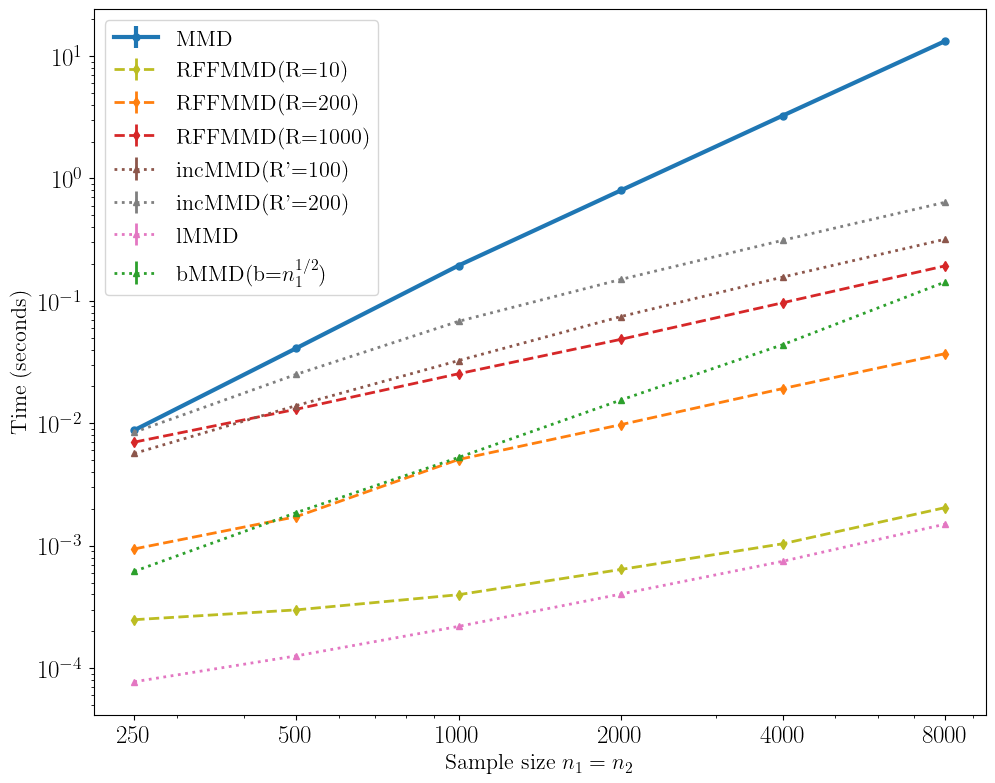

In [22]:
f, axs = plt.subplots(figsize=(10,8))
f.tight_layout()
f.subplots_adjust(wspace=0.1, hspace=0.45)

markersize = 5
tests_names = ["MMD", # MMD
               "RFFMMD(R=10)", # RFFMMD(R=10)
               "RFFMMD(R=200)", # RFFMMD(R=200)
               "RFFMMD(R=1000)", # RFFMMD(R=1000)
               "incMMD(R'=100)", # incMMD(R'=100)
               "incMMD(R'=200)", # incMMD(R'=200)
               "lMMD", # lMMD
               r"bMMD(b=${n}^{1/2}_1$)"] # bMMD
styles = [
        'solid',  # MMD
        'dashed', # RFFMMD(R=10)
        'dashed', # RFFMMD(R=200)
        'dashed', # RFFMMD(R=1000)
        'dotted', # incMMD(R'=100)
        'dotted', # incMMD(R'=200)
        'dotted', # lMMD
        'dotted'  # bMMD
    ]
    
markers = np.array(["o", # MMD
                    "d", # RFFMMD(R=10)
                    "d", # RFFMMD(R=200)
                    "d", # RFFMMD(R=1000)
                    "^", # incMMD(R'=100)
                    "^", # incMMD(R'=200)
                    "^", # lMMD
                    "^"  # bMMD
                    ])

colors = np.array(["C0", # MMD
                   "C8", # RFFMMD(R=10)
                   "C1", # RFFMMD(R=200)
                   "C3", # RFFMMD(R=1000)
                   "C5", # incMMD(R'=100)
                   "C7", # incMMD(R'=200)
                   "C6", # lMMD
                   "C2"  # bMMD
                  ])
linewidths=np.array([3,  # MMD
                     2,  # except MMD
                     2,
                     2,
                     2,
                     2,
                     2,
                     2
                    ])

time_mean =np.load("results/statruntimes_mean.npy")
time_std =np.load("results/statruntimes_std.npy")
sample_sizes =np.load("results/statruntimes_size.npy")
ylims = (80, 5, 1)
for j in [0,1,2,3,4,5,6,7]:
    axs.errorbar(sample_sizes, time_mean[j], time_std[j], color=colors[j], marker=markers[j], linestyle=styles[j], label=tests_names[j], markersize=markersize, linewidth=linewidths[j])
axs.set_xlabel(r"Sample size $n_1=n_2$", fontsize=16, labelpad=5)
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xticks(sample_sizes)
axs.set_xticklabels(sample_sizes)
axs.set_ylabel("Time (seconds)", labelpad=5, fontsize=16)

# Legend
handles, labels = axs.get_legend_handles_labels()
axs.legend(
    fontsize=16,
    ncol=1,
    loc="upper left"
)